In [14]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

In [2]:
# load hairpin data
data_path = 'data_peter/random_sequences_with_custom_hl.hdf5'
with h5py.File(data_path) as dataset:
    X_train_seq = np.expand_dims(np.array(dataset['train_seq']).transpose([0, 2, 1]), axis=2)
    X_train_struct = np.expand_dims(np.array(dataset['train_structures']).transpose([0, 2, 1]), axis=2)
    Y_train = np.expand_dims(np.array(dataset['train_targets']), axis=1)
    X_test_seq = np.expand_dims(np.array(dataset['test_seq']).transpose([0, 2, 1]), axis=2)
    X_test_struct = np.expand_dims(np.array(dataset['test_structures']).transpose([0, 2, 1]), axis=2)
    Y_test = np.expand_dims(np.array(dataset['test_targets']), axis=1)

num_data, seq_length, _, num_alphabet = X_train_seq.shape

# get validation set from training set
valid_frac = 0.2
N = len(X_train_seq)
split_index = int(N*valid_frac)
shuffle = np.random.permutation(N)

# put in a dictionary for deepomics
train = {'inputs': X_train_seq[shuffle[split_index:]], 
         'targets': Y_train[shuffle[split_index:]]}
valid = {'inputs': X_train_seq[shuffle[:split_index]], 
         'targets': Y_train[shuffle[:split_index]]}
test = {'inputs': X_test_seq, 'targets': Y_test}




In [3]:
def cnn_model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input', #41
            'input_shape': input_shape
            }
    layer2 = {'layer': 'conv1d',
            'num_filters': 96,
            'filter_size': input_shape[1]-29,
            'norm': 'batch',
            'activation': 'relu',
            'dropout': 0.3,
            'padding': 'VALID',
            }
    layer3 = {'layer': 'conv1d_residual',
            'filter_size': 5,
            'function': 'relu',
            'dropout_block': 0.1,
            'dropout': 0.3,
            'mean_pool': 10,
            }
    layer4 = {'layer': 'conv1d',
            'num_filters': 196,
            'filter_size': 3,
            'norm': 'batch',
            'activation': 'relu',
            'dropout': 0.5,
            'padding': 'VALID',
            }
    layer5 = {'layer': 'dense',
            'num_units': output_shape[1],
            'activation': 'sigmoid'
            }

    model_layers = [layer1, layer2, layer3, layer4, layer5]

    # optimization parameters
    optimization = {"objective": "binary",
                  "optimizer": "adam",
                  "learning_rate": 0.0003,
                  "l2": 1e-5,
                  #"label_smoothing": 0.05,
                  #"l1": 1e-6,
                  }
    return model_layers, optimization

tf.reset_default_graph()

# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = 'results/trial'
param_path = os.path.join(save_path, 'hairpin')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

In [4]:
# look at the shapes of each layer
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 41, 1, 4)
layer2: conv1d_0
(?, 30, 1, 96)
layer3: conv1d_0_batch
(?, 30, 1, 96)
layer4: conv1d_0_active
(?, 30, 1, 96)
layer5: conv1d_0_dropout
(?, 30, 1, 96)
layer6: conv1d_residual_0_1resid
(?, 30, 1, 96)
layer7: conv1d_residual_0_1resid_norm
(?, 30, 1, 96)
layer8: conv1d_residual_0_1resid_active
(?, 30, 1, 96)
layer9: conv1d_residual_0_dropout1
(?, 30, 1, 96)
layer10: conv1d_residual_0_2resid
(?, 30, 1, 96)
layer11: conv1d_residual_0_2resid_norm
(?, 30, 1, 96)
layer12: conv1d_residual_0_resid_sum
(?, 30, 1, 96)
layer13: conv1d_residual_0_resid
(?, 30, 1, 96)
layer14: conv1d_residual_0_meanpool
(?, 3, 1, 96)
layer15: conv1d_residual_0_dropout
(?, 3, 1, 96)
layer16: conv1d_1
(?, 1, 1, 196)
layer17: conv1d_1_batch
(?, 1, 1, 196)
layer18: conv1d_1_active
(?, 1, 1, 196)
layer19: conv1d_1_dropout


In [8]:
# initialize session
sess = utils.initialize_session()

In [9]:
#Get Predictions

# calculate activations
predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
predictionslogits = nntrainer.get_activations(sess, test, layer='dense_0_bias')

In [10]:
def firstordermut_saliency(X, layer, alphabet, figsize=(15,2)):

    ''' requires that deepomics is being used and the appropriate architecture has already been constructed
    Must first initialize the session and set best parameters

    layer is the activation layer we want to use as a string
    figsize is the figure size we want to use'''

    #first mutate the sequence
    X_mut = mf.mutate(X, X.shape[1], X.shape[3])

    #take all the mutations and assign them into a dict for deepomics
    mutations = {'inputs': X_mut, 'targets': np.ones((X_mut.shape[0], 1))}
    #Get output or logits activations for the mutations
    mut_predictions = nntrainer.get_activations(sess, mutations, layer=layer)


    #take the WT and put it into a dict for deepomics
    WT = {'inputs': X, 'targets': np.ones((X.shape[0], 1))}
    #Get output or logits activations for the WT sequence
    predictions = nntrainer.get_activations(sess, WT, layer=layer)

    #shape the predictions of the mutations into the shape of a heatmap
    heat_mut = mut_predictions.reshape(X.shape[1],4).T
    
    #normalize the heat map rearrangement by minusing it by the true prediction score of that test sequence
    norm_heat_mut = heat_mut - predictions[0]
    norm_heat_mut = utils.normalize_pwm(norm_heat_mut, factor=4)

    plt.figure(figsize=figsize)
    visualize.plot_seq_pos_saliency(np.squeeze(X).T, 
                                        norm_heat_mut,
                                        alphabet=alphabet, 
                                        nt_width=400) 

/Users/steffanpaul/Eddy Lab/RNA_secstructure/deepomics/utils.py:111: RuntimeWarning: invalid value encountered in true_divide
  pwm = pwm/MAX
/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


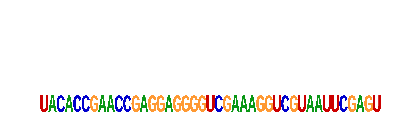

In [15]:
# sort activations
import mutagenesis_functions as mf

plot_index = np.argsort(predictionsoutput[:,0])[::-1]

X = np.expand_dims(test['inputs'][plot_index[0]], axis=0)

firstordermut_saliency(X, layer='output', alphabet='rna')

/Users/steffanpaul/Eddy Lab/RNA_secstructure/deepomics/utils.py:111: RuntimeWarning: invalid value encountered in true_divide
  pwm = pwm/MAX
/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


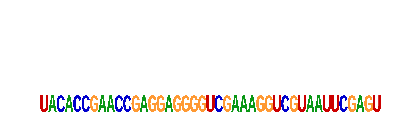

In [26]:
import mutagenesis_functions as mf

# initialize session
sess = utils.initialize_session()

plot_index = np.argsort(predictionsoutput[:,0])[::-1]

X = np.expand_dims(test['inputs'][plot_index[0]], axis=0)

layer = 'output'
alphabet = 'rna'
figsize = (15,2)

#first mutate the sequence
X_mut = mf.mutate(X, X.shape[1], X.shape[3])

#take all the mutations and assign them into a dict for deepomics
mutations = {'inputs': X_mut, 'targets': np.ones((X_mut.shape[0], 1))}
#Get output or logits activations for the mutations
mut_predictions = nntrainer.get_activations(sess, mutations, layer=layer)


#take the WT and put it into a dict for deepomics
WT = {'inputs': X, 'targets': np.ones((X.shape[0], 1))}
#Get output or logits activations for the WT sequence
predictions = nntrainer.get_activations(sess, WT, layer=layer)

#shape the predictions of the mutations into the shape of a heatmap
heat_mut = mut_predictions.reshape(X.shape[1],4).T

#normalize the heat map rearrangement by minusing it by the true prediction score of that test sequence
norm_heat_mut = heat_mut - predictions[0]
norm_heat_mut = utils.normalize_pwm(norm_heat_mut, factor=4)

plt.figure(figsize=figsize)
visualize.plot_seq_pos_saliency(np.squeeze(X).T, 
                                    norm_heat_mut,
                                    alphabet=alphabet, 
                                    nt_width=400) 

In [27]:
predictions = nntrainer.get_activations(sess, WT, layer=layer)

mut_predictions

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
      